# Progetto Finale di introduzione alla DataScience
Con questo notebook ci poniamo l'obiettivo di:
1. capire quale sia la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download (che, da adesso, per brevità, chiameremo nr/nd)

2. capire, dentro a questa categoria, se sono generalmente le app a pagamento o quelle free ad avere un nr/nd più alto

3. investigare l'esistenza di una eventuale correlazione tra il nr/nd e il rating di una applicazione: se questa metrica cresce, generalmente, il rating aumenterà? Diminuirà? Nessuna delle due? Proveremo a scoprirlo

Le ipotesi formulate sono quindi le seguenti:
1. immaginiamo che la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download siano le app di categoria PRODUCTIVITY (e pensiamo che la categoria SOCIAL sia la seconda) 
2. immaginiamo che, all'interno della categoria trovata, generalmente, le app a pagamento avranno un nr/nd più alto rispetto a quelle free (perché pensiamo che un utente sia più motivato a lasciare una recensione, sia esponendo criticità che punti di forza, quando ha pagato per un prodotto, piuttosto che quando ne ha usufruito gratis)
3. immaginiamo che, al crescere del rapporto nr/nd diminuisca il rating (perché pensiamo che, di solito, se la maggior parte degli utilizzatori lascia una recensione, è per criticare qualcosa piuttosto che per esprimere soddisfazione)




 <br>Trovare la categoria di app che "eccelle" più delle altre in questa metrica potrebbe aiutare, ad esempio, una software house che vuole sviluppare applicazioni particolarmente innovative o che per qualche motivo hanno bisogno di tanti feedback anche dopo varie release: conoscendo i risultati di questa analisi, saprà su quale categoria puntare, avendo trovato la user-base più "attiva" possibile.

## Pulizia ed Analisi Iniziale


### Diamo una occhiata al dataset

In [1]:
## importiamo il necessario:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
import scipy.stats as stats
import sklearn
#importiamo il dataset e visualizziamo prime 5 righe:
playstore = pd.read_csv('googleplaystore.csv')
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [2]:
#visualizziamo numero di righe e colonne:
print("Numero Righe, Numero Colonne",playstore.shape)

Numero Righe, Numero Colonne (10841, 13)


In [3]:
#visualizziamo le informazioni del dataset:
playstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
#visualizziamo eventuali valori nulli:
playstore.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Come vediamo ci sono ben 1474 righe che hanno valore nullo sulla colonna Rating, potremmo pensare di
* rimuovere tutte queste righe (e quindi ridurre significativamente la dimensione del nostro dataset)
* "completare" i valori nulli usando il valore medio del rating.

Optiamo per la prima opzione, in quanto la seconda potrebbe portare ad una distorsione dei dati per quanto riguarda l'analisi che ci proponiamo di attuare, infatti, se pensiamo di voler cercare una correlazione tra nr/nd e Rating ed usiamo il valore medio in tutte le righe che presentano attualmente un valore nullo, avremo dei risultati irrealistici in tutte queste righe,

#### *esempio*:
il rating medio è 2.3, quindi in 1474 entrate avremo il valore 2.3 sulla colonna Rating, ciò significa che poi, quando andremo a cercare una correlazione, potremmo avere:
* App 1: rating = 2.3, nr/nd = 40%
* App 2: rating = 2.3, nr/nd = 60%
* App 3: rating = 2.3, nr/nd = 99%

e la nostra analisi è stata inquinata, quando magari, rimuovendo le entrate in cui Rating è nullo avremmo trovato una correlazione

### Puliamo il dataset

In [5]:
#eliminiamo le righe con valori nulli nella colonna 'Rating':
playstore = playstore.dropna(axis=0, subset=['Rating'])
playstore.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    1
Genres            0
Last Updated      0
Current Ver       4
Android Ver       3
dtype: int64

Analizzando il dataset individuiamo le caratteristiche che, a nostro parere, dovrebbero essere quantitative:
* Rating 
* Reviews
* Installs
* Size
* Price


In [6]:
playstore.describe() #visualizziamo statistiche del dataset

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


Notiamo che utilizzando il metodo describe abbiamo informazioni solo sulla colonna Rating, come mai le altre (anche se pensiamo essere quantitative) non vengono mostrate?<br>Perché contengono valori come stringhe.

#### Pulizia righe rumorose
Inoltre notiamo qualcosa di "curioso" rispetto al valore massimo della colonna Rating, se i rating sul playstore vanno da 1 a 5 stelle, come è possibile che il valore massimo sia 19? C'è una riga problematica nel nostro dataset, che decidiamo di eliminare, in quanto, probabilmente a causa di un errore nel processo di raccolta dei dati, risulta "disallineata", ovvero i valori sono spostati di una colonna:

In [7]:
righe_rumorose = playstore[(playstore['Rating']>5) | (playstore['Rating']<1)]
print("Numero di righe problematiche rispetto al rating: ",righe_rumorose.shape[0]) # controlliamo quante sono, e scopriamo che c'è una sola riga di questo tipo
(righe_rumorose.head(1)) # quindi la visualizziamo con head

Numero di righe problematiche rispetto al rating:  1


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


I valori risultano chiaramente spostati di una colonna (dovrebbe essere Rating = 1.9, Reviews=19, Size = 3.0M, eccetera), ma se volessimo "sistemare" questa colonna ci troveremmo con un valore nullo dentro alla colonna Category, il che non ci fa comodo perché vogliamo fare l'analisi proprio su questa colonna. Quindi decidiamo di eliminare interamente la riga.

In [8]:
(playstore.describe()) # prima di eliminarla, ri-visualizziamo le statistiche del dataset


,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [9]:
playstore = playstore.drop(righe_rumorose.index, axis=0) # eliminiamo la riga rumorosa
playstore.describe() # visualizziamo le statistiche del dataset dopo aver eliminato la riga rumorosa

,Rating
count,9366.000000
mean,4.191757
std,0.515219
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


#### Pulizia dei valori duplicati

In [10]:
#visualizziamo il numero di valori duplicati quindi con lo stesso valore sotto la colonna app:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())
#eliminiamo i valori duplicati:
playstore = playstore.drop_duplicates(subset=['App'])
#verifichiamo che non ci siano più valori duplicati:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())


Numero di valori duplicati:  1170
Numero di valori duplicati:  0


Torniamo sulle variabili Install, Reviews, Price e Size, che dovrebbero risultare quantitative ma non accade. Prima di tutto guardiamo il tipo

In [11]:
print("Tipo di Installs:\t" + str(type(playstore['Installs'][0])))
print("Tipo di Reviews:\t" + str(type(playstore['Reviews'][0])))
print("Tipo di Price:\t\t" + str(type(playstore['Price'][0])))
print("Tipo di Size:\t\t" + str(type(playstore['Size'][0])))

Tipo di Installs:	<class 'str'>
Tipo di Reviews:	<class 'str'>
Tipo di Price:		<class 'str'>
Tipo di Size:		<class 'str'>


Notiamo che sono appunto tutte stringhe.
Le uniche colonne che però ci interessa realmente pulire e "rendere quantitative" sono: Installs e Reviews, in quanto Price e Size non giocano alcun ruolo nella nostra analisi.

#### Trasformiamo Installs
Installs contiene valore in formato stringa perché il numero di download è espresso nella forma n+, per indicare che l'app è stata scaricata "più di n volte"

In [12]:
if(type(playstore['Installs'][0]) is str):
    playstore['Installs'] = [int(x.replace('+','').replace(',','')) for x in playstore['Installs']]
# ri-controlliamo le statistiche:
playstore.describe()

,Rating,Installs
count,8196.000000,8.196000e+03
mean,4.173243,9.165090e+06
std,0.536625,5.825087e+07
min,1.000000,1.000000e+00
25%,4.000000,1.000000e+04
50%,4.300000,1.000000e+05
75%,4.500000,1.000000e+06
max,5.000000,1.000000e+09


#### Trasformiamo Reviews
Reviews contiene valore in formato stringa, lo trasformiamo in numero

In [13]:
if(type(playstore['Reviews'][0]) is str):
    playstore['Reviews'] = playstore['Reviews'].astype(int)
# ri-controlliamo le statistiche:
playstore.describe()

,Rating,Reviews,Installs
count,8196.000000,8.196000e+03,8.196000e+03
mean,4.173243,2.552515e+05,9.165090e+06
std,0.536625,1.985594e+06,5.825087e+07
min,1.000000,1.000000e+00,1.000000e+00
25%,4.000000,1.260000e+02,1.000000e+04
50%,4.300000,3.004000e+03,1.000000e+05
75%,4.500000,4.381300e+04,1.000000e+06
max,5.000000,7.815831e+07,1.000000e+09


#### Drop di colonne che non utilizzeremo
Per completare la pulizia, infine, eliminiamo dal dataset le colonne Price e Size (menzionate sopra) e Content Rating, Genres, Last Updated, Current Ver e Android Ver perché di nulla utilità rispetto al nostro obiettivo

In [14]:
playstore.drop(columns=['Price', 'Size', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], inplace=True)
playstore.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8196 entries, 0 to 10840
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   App       8196 non-null   object 
 1   Category  8196 non-null   object 
 2   Rating    8196 non-null   float64
 3   Reviews   8196 non-null   int64  
 4   Installs  8196 non-null   int64  
 5   Type      8196 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 706.3+ KB


#### Considerazione sul numero di download:
Ha senso, ai fini della nostra analisi, considerare applicazioni con un numero relativamente basso di installazioni?<br>
Immaginiamo lo sviluppatore 'indie' che fa scaricare e recensire la sua app appena sviluppata a 5 suoi conoscenti, quando andremo a calcolare il nostro rapporto nr/nd avremo 100%, ma è davvero significativo?<br>
Risulta essere un indicatore realmente affidabile su un così basso numero di utenti?<br>
Per questo motivo decidiamo di non considerare le applicazioni con meno di 10000 Installs

In [15]:
# togliamo tutte le applicazioni con meno di 10000 installs:
playstore = playstore[playstore['Installs'] >= 10000]

#### Calcolo del rapporto nr/nd:

In [16]:
# calcoliamo il rapporto tra numero di recensioni e numero di installazioni:
playstore['nr/nd'] = playstore['Reviews'] / playstore['Installs'] * 100
playstore.describe()
# ordiniamo il dataset in base al rapporto tra numero di recensioni e numero di installazioni:
playstore = playstore.sort_values(by='nr/nd', ascending=False)
playstore.head(20) # diamo una occhiata alle prime 20 righe

,App,Category,Rating,Reviews,Installs,Type,nr/nd
4663,Alarmy (Sleep If U Can) - Pro,LIFESTYLE,4.8,10249,10000,Paid,102.490000
7165,My Movies Pro - Movie & TV Collection Library,LIFESTYLE,4.6,6477,10000,Paid,64.770000
9304,Carrier Landings Pro,FAMILY,4.6,5969,10000,Paid,59.690000
9627,ai.type keyboard Plus + Emoji,TOOLS,4.5,57076,100000,Paid,57.076000
4946,Flud (Ad free),VIDEO_PLAYERS,4.8,5639,10000,Paid,56.390000
4556,Day R Premium,FAMILY,4.8,51068,100000,Paid,51.068000
7610,Ski Safari: Adventure Time,FAMILY,4.5,48754,100000,Paid,48.754000
1670,Clash of Clans,GAME,4.6,44891723,100000000,Free,44.891723
4203,The World Ends With You,GAME,4.6,4108,10000,Paid,41.080000
3442,Smart Launcher Pro 3,PERSONALIZATION,4.6,40704,100000,Paid,40.704000


#### Problema di precisione nei dati
Notiamo valori sospetti dopo aver calcolato nr/nd ed aver ordinato le righe del dataframe in base a questa metrica (ad esempio un rapporto del 102% dovuto al fatto che ci fossero 10249 reviews per una applicazione installata 10000 volte) questo ci ha portato a ulteriori controlli sui dati. <br>
Siamo ritornati a pulire i dati, in quanto non è possibile che, per una certa applicazione, ci siano più reviews che installazioni.
Ma perché accade questo? Con tutta probabilità, ciò è causato dal fatto che il numero di installazioni non è un numero preciso, bensì un range (infatti come abbiamo detto in precedenza, era indicato nella forma del tipo n+), questo significa che, se una applicazione ha "1+ downloads" essa ha un numero di downloads maggiore o uguale a 1 e però minore di 5, se una applicazione ha un numero di downloads listato come 1,000+ significa che ha tra le 1,000 e  le 5,000 installazioni, e così via.
Mentre, il numero di reviews è un numero preciso.
Per cercare di arginare questo problema procediamo eliminando dal dataset le righe in cui il nr/nd è superiore a 100


In [17]:
# eliminiamo dal dataset le righe in cui nr/nd è maggiore di 100:
playstore = playstore[playstore['nr/nd'] <= 100]
playstore.describe()

,Rating,Reviews,Installs,nr/nd
count,6434.000000,6.434000e+03,6.434000e+03,6434.000000
mean,4.178007,3.251396e+05,1.167456e+07,3.047394
std,0.438951,2.236008e+06,6.552293e+07,4.228255
min,1.600000,6.000000e+00,1.000000e+04,0.000660
25%,4.000000,9.630000e+02,1.000000e+05,0.854685
50%,4.300000,1.066500e+04,1.000000e+06,1.729950
75%,4.500000,7.826650e+04,5.000000e+06,3.539497
max,5.000000,7.815831e+07,1.000000e+09,64.770000


&emsp;&emsp;&emsp;&emsp;&emsp;👆🏼Notiamo anche che considerando solo le app con 10,000 download o più, il rating minimo si è alzato da 1 a 1.6

### Distribuzione delle categorie
Una volta completata la pulizia, iniziamo a cercare di capire meglio la struttura dei nostri dati; cominciamo visualizzando la distribuzione delle categorie delle app nello store

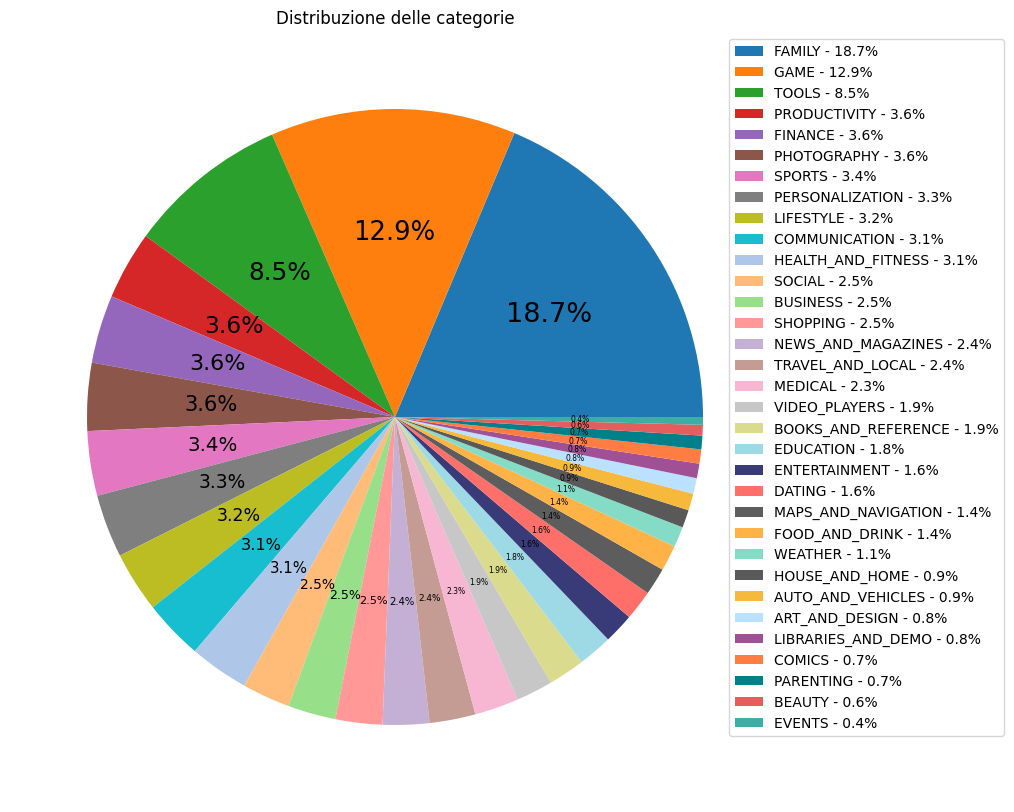

In [18]:
import matplotlib.pyplot as plt

# Genera una lista di 33 colori diversi
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
                 '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
                 '#393b79', '#ff6f69', '#5d5d5d', '#ffb347', '#84dcc6',
                 '#595959', '#f6b93b', '#bae1ff', '#a05195', '#ff7c43',
                 '#00818a', '#e55e5e', '#3caea3']

percentages = (playstore['Category'].value_counts() / len(playstore)) * 100
labels = [f'{label} - {percentage:.1f}%' for label, percentage in zip(percentages.index, percentages)]

# Plot del grafico a torta
pie = playstore['Category'].value_counts().plot.pie(fontsize=10, autopct='%1.1f%%', figsize=(10,10), colors=color_palette, labels=None, labeldistance=0.7)
plt.ylabel('')
plt.title('Distribuzione delle categorie')
plt.subplots_adjust(right=1.7)  # spazio a destra per la legenda

# Modifica la dimensione del font delle etichette in base alla dimensione delle fette
sizePerc=20
count=1
for text in pie.texts:
    text.set_fontsize(sizePerc)
    if (count<=33):
        sizePerc-=0.44
    count+=1
count=1
sizePerc=20
plt.legend(labels=labels, loc='upper right', bbox_to_anchor=(1.3, 1))
# Mostra il grafico
plt.show()



## Risoluzione obiettivo 1:
Cerchiamo di capire quale è la categoria con il rapporto tra numero di recensioni e numero di installazioni più alto

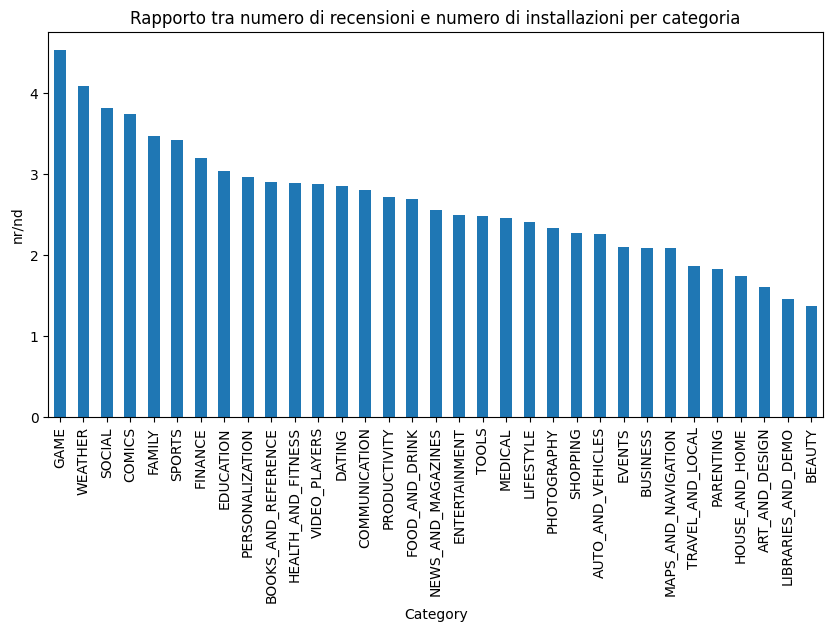

In [19]:
playstore.groupby('Category')['nr/nd'].mean().sort_values(ascending=False).plot.bar(figsize=(10,5)) # ordiniamo le categorie in base al rapporto tra numero di recensioni e numero di installazioni, prendendo ogni categoria e calcolando la media di nr/nd
plt.ylabel('nr/nd')
plt.title('Rapporto tra numero di recensioni e numero di installazioni per categoria')
plt.show()

Abbiamo quindi scoperto che la categoria di applicazioni con nr/nd più alto è la categoria GAME, differentemente da quanto ci aspettavamo (avendo inizialmente ipotizzato PRODUCTIVITY)

## Olap
Prepariamo i dati per la rappresentazione multidimensionale e iniziamo a visualizzare

In [20]:
# Recuperiamo le diverse categorie per la rappresentazione OLAP
quantize_category = np.unique(playstore['Category'])
print("Numero di categorie: ", len(quantize_category))
quantize_rating = ['BAD', 'SUFFICIENT', 'GOOD', 'EXCELLENT']
quantize_nr_nd = ['LOW', 'MEDIUM', 'HIGH']


playstore.info()



Numero di categorie:  33
<class 'pandas.core.frame.DataFrame'>
Index: 6434 entries, 7165 to 3268
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   App       6434 non-null   object 
 1   Category  6434 non-null   object 
 2   Rating    6434 non-null   float64
 3   Reviews   6434 non-null   int64  
 4   Installs  6434 non-null   int64  
 5   Type      6434 non-null   object 
 6   nr/nd     6434 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 402.1+ KB


In [21]:
playstore.loc[playstore['nr/nd'].between(0, 15), 'nr/nd_quant'] = quantize_nr_nd[0]
playstore.loc[playstore['nr/nd'].between(15, 35), 'nr/nd_quant'] = quantize_nr_nd[1]
playstore.loc[playstore['nr/nd'].between(35, 100), 'nr/nd_quant'] = quantize_nr_nd[2]

playstore.loc[playstore['Rating'] < 2.5, 'Rating_quant'] = quantize_rating[0]
playstore.loc[playstore['Rating'].between(2.5, 3.5), 'Rating_quant'] = quantize_rating[1]
playstore.loc[playstore['Rating'].between(3.6, 4.5), 'Rating_quant'] = quantize_rating[2]
playstore.loc[playstore['Rating'] >4.5, 'Rating_quant'] = quantize_rating[3]



In [22]:
results = pd.DataFrame(columns=['Category', 'Rating', 'nr/nd', 'Count'])
playstore['combined'] = playstore['Category'] + " / " + playstore['Rating_quant'] + " / " + playstore['nr/nd_quant']
playstore.head()


,App,Category,Rating,Reviews,Installs,Type,nr/nd,nr/nd_quant,Rating_quant,combined
7165,My Movies Pro - Movie & TV Collection Library,LIFESTYLE,4.6,6477,10000,Paid,64.770,HIGH,EXCELLENT,LIFESTYLE / EXCELLENT / HIGH
9304,Carrier Landings Pro,FAMILY,4.6,5969,10000,Paid,59.690,HIGH,EXCELLENT,FAMILY / EXCELLENT / HIGH
9627,ai.type keyboard Plus + Emoji,TOOLS,4.5,57076,100000,Paid,57.076,HIGH,GOOD,TOOLS / GOOD / HIGH
4946,Flud (Ad free),VIDEO_PLAYERS,4.8,5639,10000,Paid,56.390,HIGH,EXCELLENT,VIDEO_PLAYERS / EXCELLENT / HIGH
4556,Day R Premium,FAMILY,4.8,51068,100000,Paid,51.068,HIGH,EXCELLENT,FAMILY / EXCELLENT / HIGH


In [23]:
counts = playstore['combined'].value_counts()

for z in range(0,len(quantize_category)):
    for j in range(0,len(quantize_rating)):
        for i in range(0,len(quantize_nr_nd)):
            key = f"{quantize_category[z]} / {quantize_rating[j]} / {quantize_nr_nd[i]}"
            #print("Key: ", key) # per vedere come si chiama la chiave (debug)
            count = counts.get(key, 0)
#Aggiungiamo i risultati al dataframe
            results.loc[len(results)] = [quantize_category[z], quantize_rating[j], quantize_nr_nd[i], count]
results.head(1000)


,Category,Rating,nr/nd,Count
0,ART_AND_DESIGN,BAD,LOW,0
1,ART_AND_DESIGN,BAD,MEDIUM,0
2,ART_AND_DESIGN,BAD,HIGH,0
3,ART_AND_DESIGN,SUFFICIENT,LOW,1
4,ART_AND_DESIGN,SUFFICIENT,MEDIUM,0
...,...,...,...,...
391,WEATHER,GOOD,MEDIUM,3
392,WEATHER,GOOD,HIGH,0
393,WEATHER,EXCELLENT,LOW,7
394,WEATHER,EXCELLENT,MEDIUM,2


Visualizziamo ricordandoci che abbiamo:
* 33 possibili valori per Category
* 4 possibili valori per Rating
* 3 possibili valori per nr/nd

In [24]:
# printiamo il valore massimo di count
print("Massimo: ", results['Count'].max())
# ordiniamo il dataframe results in base alla colonna count
results = results.sort_values(by='Count', ascending=False)
results.head(10)

Massimo:  901


,Category,Rating,nr/nd,Count
138,FAMILY,GOOD,LOW,901
174,GAME,GOOD,LOW,642
354,TOOLS,GOOD,LOW,399
294,PHOTOGRAPHY,GOOD,LOW,182
306,PRODUCTIVITY,GOOD,LOW,176
78,COMMUNICATION,GOOD,LOW,172
150,FINANCE,GOOD,LOW,165
141,FAMILY,EXCELLENT,LOW,160
342,SPORTS,GOOD,LOW,159
282,PERSONALIZATION,GOOD,LOW,158


### Interpretazione della visualizzazione qua sopra
La tabella results di cui abbiamo visualizzato alcune righe ci comunica le seguenti informazioni riguardo al nostro dataset, rispondendo a questa domanda:<br>
Quante sono le applicazioni della categoria X che abbiano un rating buono (o cattivo) ed un nr/nd basso (o medio, o alto)? <br>La risposta a questa domanda viene fornita dalla colonna Count, che conta per l'appunto il numero di occorrenze di tali applicazioni.
#### *esempio*:
ci sono 901 applicazioni della categoria FAMILY che hanno un rating GOOD ed un nr/nd LOW.

### Prima visualizzazione OLAP proposta
Siccome abbiamo notato che la categoria FAMILY è quella che si "prende la fetta più grande" tra le categorie di applicazioni dello store, e che GAME è quella mediamente con il rapporto nr/nd più alto, pensiamo sia interessante fare una visualizzazione OLAP per quanto riguarda queste categorie.

#### Slicing su app di categoria FAMILY

In [25]:
family_results = results.loc[results['Category'] == 'FAMILY']
print(family_results)

    Category      Rating   nr/nd  Count
138   FAMILY        GOOD     LOW    901
141   FAMILY   EXCELLENT     LOW    160
135   FAMILY  SUFFICIENT     LOW     90
139   FAMILY        GOOD  MEDIUM     18
142   FAMILY   EXCELLENT  MEDIUM     17
132   FAMILY         BAD     LOW     10
143   FAMILY   EXCELLENT    HIGH      3
140   FAMILY        GOOD    HIGH      2
137   FAMILY  SUFFICIENT    HIGH      0
136   FAMILY  SUFFICIENT  MEDIUM      0
134   FAMILY         BAD    HIGH      0
133   FAMILY         BAD  MEDIUM      0


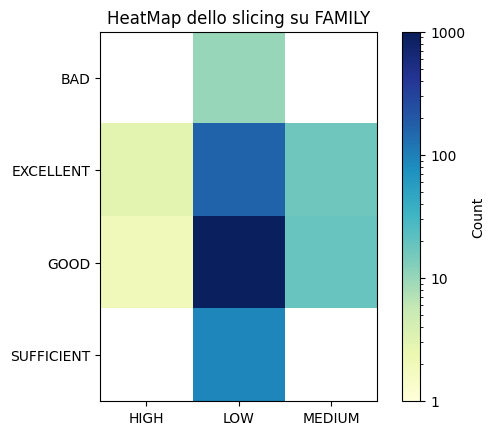

In [26]:
# Trasformiamo i dati in una matrice utilizzando il metodo pivot
matrix = family_results.pivot(index='Rating', columns='nr/nd', values='Count')
# Creiamo la heatmap utilizzando imshow
plt.imshow(matrix, cmap='YlGnBu', interpolation='nearest', norm=mcolors.LogNorm(vmin=1, vmax=1000))

# Aggiungiamo una colorbar per indicare il valore dei colori
cbar = plt.colorbar(label='Count')

# Impostiamo le etichette degli assi
plt.xticks(np.arange(len(matrix.columns)), matrix.columns)
plt.yticks(np.arange(len(matrix.index)), matrix.index)

plt.title('HeatMap dello slicing su FAMILY')

# Modifichiamo le etichette della colorbar, ci sembra più chiaro avere 1, 10, 100, 1000 espressi così, piuttosto che come potenze di 10 (di default)
ticks = [1, 10, 100, 1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# Mostriamo il grafico
plt.show()

Con questo slicing notiamo che la maggior parte delle app per famiglie hanno un nr/nd basso e che la maggior parte di esse hanno un rating buono.
In particolare, abbiamo visto precedentemente che le app di categoria family sono le più numerose, con una percentuale del 18.7 %. Le app di questa categoria sono 1201 e con questa visualizzazione OLAP vediamo come addirittura circa 900 siano quelle con nr/nd basso e valutazione buona, quindi stiamo parlando del 75% delle applicazioni FAMILY.

#### Slicing su app di categoria GAME

In [27]:
game_results = results.loc[results['Category'] == 'GAME']
print(game_results)

    Category      Rating   nr/nd  Count
174     GAME        GOOD     LOW    642
177     GAME   EXCELLENT     LOW    115
171     GAME  SUFFICIENT     LOW     31
175     GAME        GOOD  MEDIUM     22
178     GAME   EXCELLENT  MEDIUM     11
179     GAME   EXCELLENT    HIGH      3
176     GAME        GOOD    HIGH      2
168     GAME         BAD     LOW      2
173     GAME  SUFFICIENT    HIGH      0
172     GAME  SUFFICIENT  MEDIUM      0
170     GAME         BAD    HIGH      0
169     GAME         BAD  MEDIUM      0


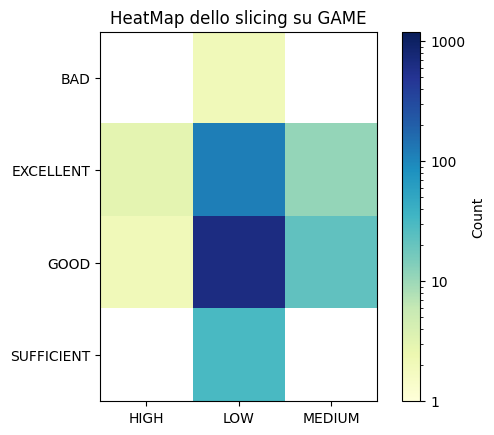

In [28]:
# Trasformiamo i dati in una matrice utilizzando il metodo pivot
matrix = game_results.pivot(index='Rating', columns='nr/nd', values='Count')
# Creiamo la heatmap utilizzando imshow
plt.imshow(matrix, cmap='YlGnBu', interpolation='nearest', norm=mcolors.LogNorm(vmin=1, vmax=1200))

# Aggiungiamo una colorbar per indicare il valore dei colori
cbar = plt.colorbar(label='Count')

# Impostiamo le etichette degli assi
plt.xticks(np.arange(len(matrix.columns)), matrix.columns)
plt.yticks(np.arange(len(matrix.index)), matrix.index)

plt.title('HeatMap dello slicing su GAME')


# Modifichiamo le etichette della colorbar, ci sembra più chiaro avere 1, 10, 100, 1000 espressi così, piuttosto che come potenze di 10 (di default)
ticks = [1, 10, 100, 1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# Mostriamo il grafico
plt.show()

Forse stiamo iniziando a notare un trend? Sia in questo slicing su GAME, che in quello su FAMILY, c'è una totale assenza di occorrenze delle combinazioni:
* (nr/nd medio, rating cattivo)
* (nr/nd alto, rating cattivo)
* (nr/nd alto, rating sufficiente)
* (nr/nd medio, rating sufficiente).
<br>

Con il codice qua sotto ci convinciamo che questo accade **su tutto il dataset** e non solo nelle categorie FAMILY e GAME

In [29]:
# Filtraggio dei dati per le combinazioni specifiche
bad_medium = results.loc[(results['Rating'] == 'BAD') & (results['nr/nd'] == 'MEDIUM')]
bad_high = results.loc[(results['Rating'] == 'BAD') & (results['nr/nd'] == 'HIGH')]
sufficient_high = results.loc[(results['Rating'] == 'SUFFICIENT') & (results['nr/nd'] == 'HIGH')]
sufficient_medium= results.loc[(results['Rating'] == 'SUFFICIENT') & (results['nr/nd'] == 'MEDIUM')]
# Controllo se tutti i valori nella colonna 'Count' sono zero
print("Tutti zeri per combinazioni (nr/nd medio, rating cattivo) di qualsiasi categoria:", bad_medium['Count'].all() == 0)
print("Tutti zeri per combinazioni (nr/nd alto, rating cattivo) di qualsiasi categoria:", bad_high['Count'].all() == 0)
print("Tutti zeri per combinazioni (nr/nd alto, rating sufficiente) di qualsiasi categoria:", sufficient_high['Count'].all() == 0)
print("Tutti zeri per combinazioni (nr/nd medio, rating sufficiente) di qualsiasi categoria:", sufficient_medium['Count'].all() == 0)


Tutti zeri per combinazioni (nr/nd medio, rating cattivo) di qualsiasi categoria: True
Tutti zeri per combinazioni (nr/nd alto, rating cattivo) di qualsiasi categoria: True
Tutti zeri per combinazioni (nr/nd alto, rating sufficiente) di qualsiasi categoria: True
Tutti zeri per combinazioni (nr/nd medio, rating sufficiente) di qualsiasi categoria: True


#### Dicing
A questo punto effetuiamo un dicing, visualizzando le app che hanno un Rating "SUFFICIENT" ed un nr/nd "LOW", in quanto è la combinazione che sembra differire in maniera più significativa guardando le due matrici di FAMILY e GAME

In [30]:
suff_low_apps = results.loc[(results['Rating'] == 'SUFFICIENT') & (results['nr/nd'] == 'LOW')]
#rimuoviamo tutte quelle con count = 0
suff_low_apps_filtered = suff_low_apps.loc[suff_low_apps['Count']>0]
print(suff_low_apps_filtered)


                Category      Rating nr/nd  Count
135               FAMILY  SUFFICIENT   LOW     90
351                TOOLS  SUFFICIENT   LOW     65
219            LIFESTYLE  SUFFICIENT   LOW     34
171                 GAME  SUFFICIENT   LOW     31
51              BUSINESS  SUFFICIENT   LOW     26
87                DATING  SUFFICIENT   LOW     21
147              FINANCE  SUFFICIENT   LOW     20
291          PHOTOGRAPHY  SUFFICIENT   LOW     20
363     TRAVEL_AND_LOCAL  SUFFICIENT   LOW     19
255   NEWS_AND_MAGAZINES  SUFFICIENT   LOW     18
375        VIDEO_PLAYERS  SUFFICIENT   LOW     17
183   HEALTH_AND_FITNESS  SUFFICIENT   LOW     17
243              MEDICAL  SUFFICIENT   LOW     15
75         COMMUNICATION  SUFFICIENT   LOW     14
339               SPORTS  SUFFICIENT   LOW     14
303         PRODUCTIVITY  SUFFICIENT   LOW     13
231  MAPS_AND_NAVIGATION  SUFFICIENT   LOW     10
159       FOOD_AND_DRINK  SUFFICIENT   LOW      8
327               SOCIAL  SUFFICIENT   LOW      7


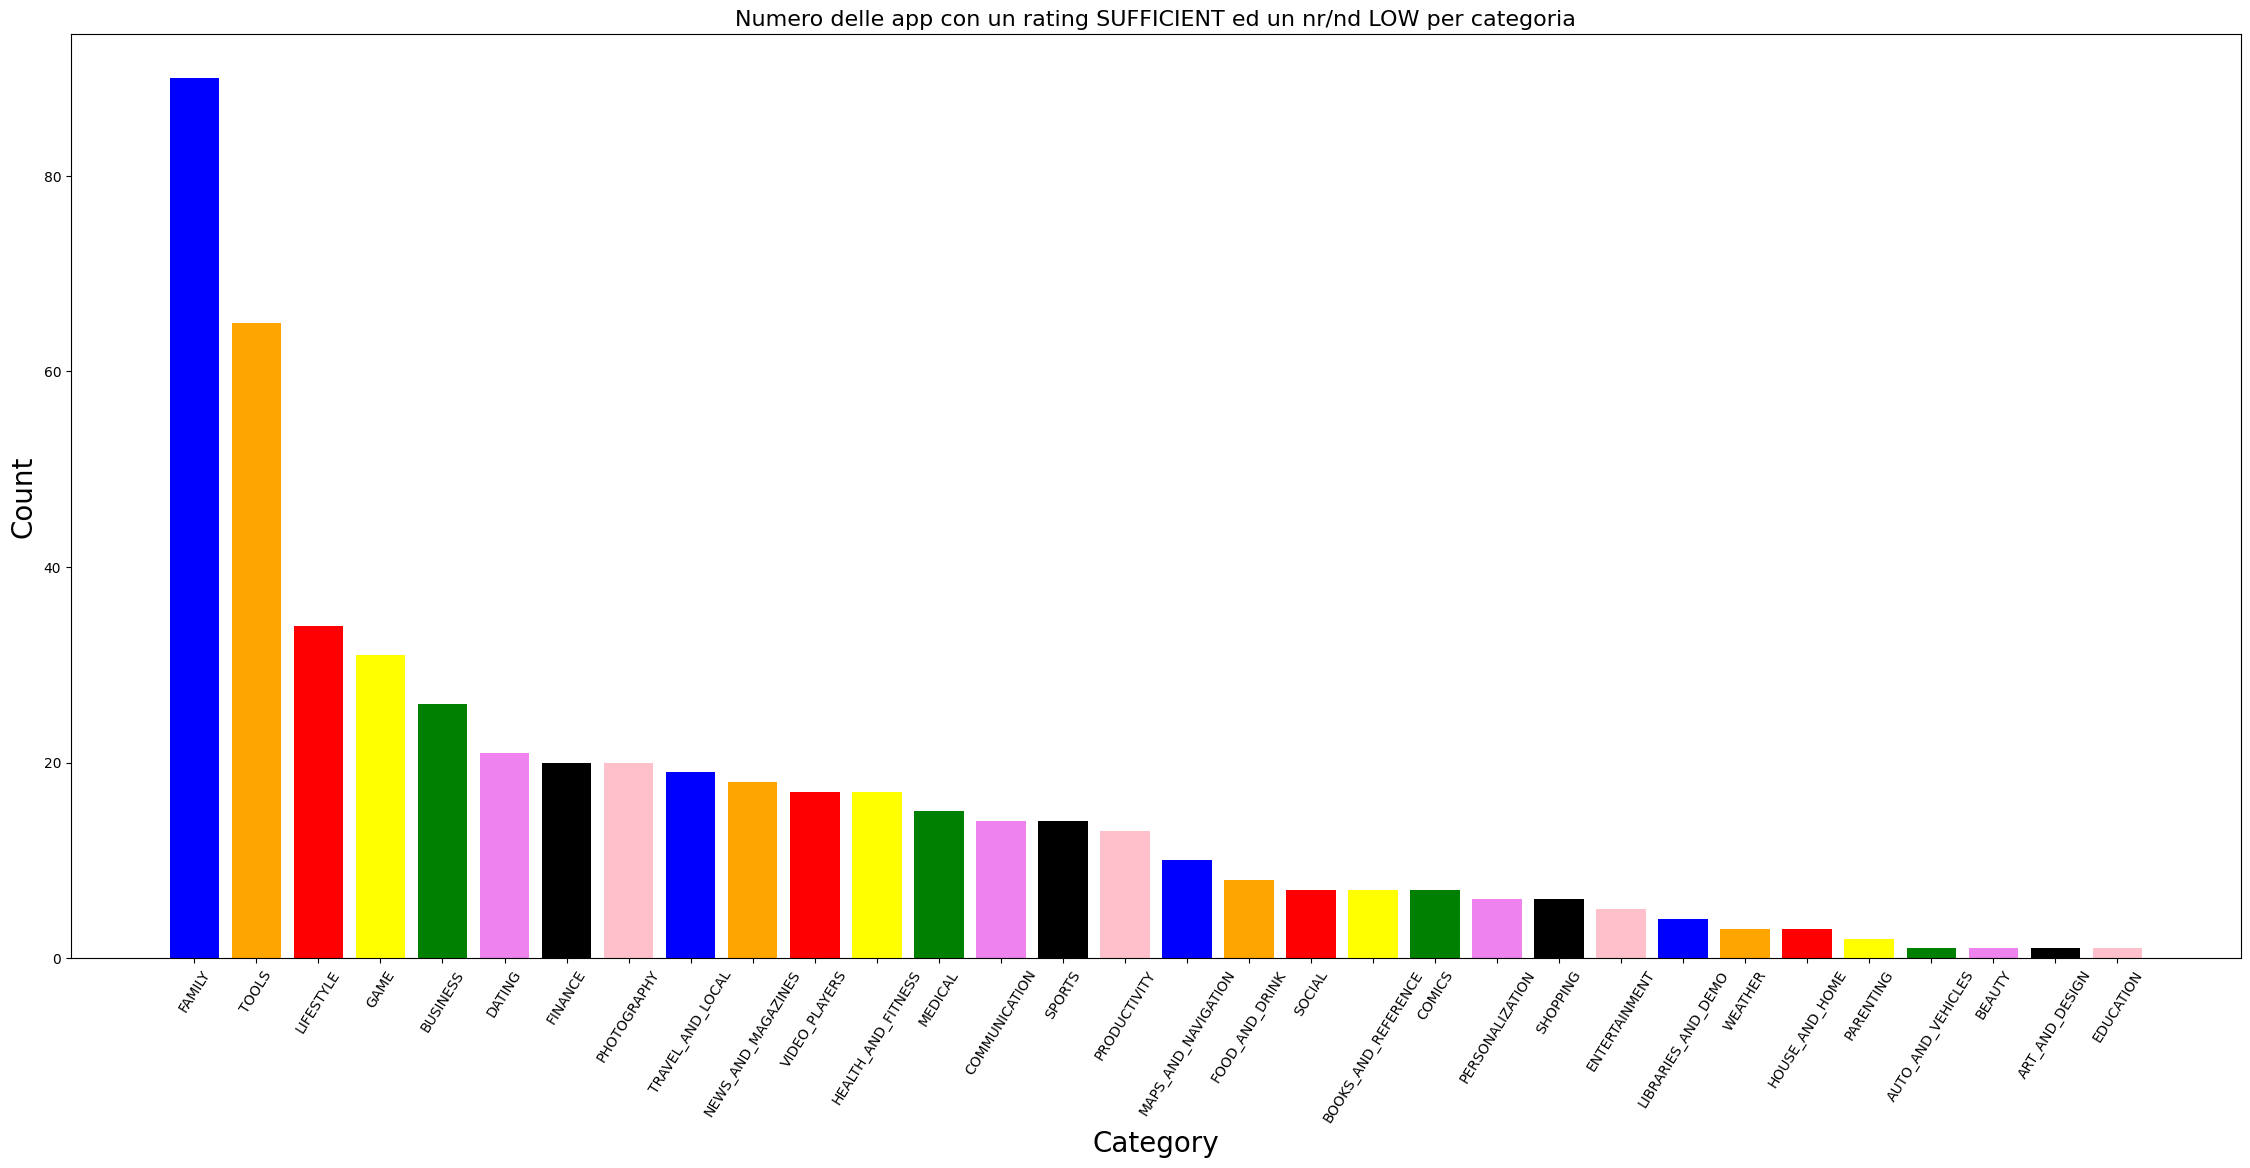

In [31]:
# Creiamo un bar plot con larghezza delle barre regolata
plt.figure(figsize=(28,12))  ## width, height
plt.bar(suff_low_apps_filtered['Category'], suff_low_apps_filtered['Count'], color=['blue', 'orange', 'red', 'yellow', 'green', 'violet', 'black', 'pink'], width=0.8)


# Impostiamo le etichette degli assi
plt.xlabel('Category', fontsize=20)
plt.ylabel('Count', fontsize=20)

# Impostiamo il titolo del grafico
plt.title('Numero delle app con un rating SUFFICIENT ed un nr/nd LOW per categoria', fontsize=16)

# Impostiamo la dimensione del font per le etichette sull'asse x
plt.xticks(fontsize=10, rotation=58)

# Mostriamo il grafico
plt.show()


Facciamo la stessa cosa, visualizzando adesso le app che hanno un Rating "GOOD" ed un nr/nd "MEDIUM"

In [32]:
good_medium_apps = results.loc[(results['Rating'] == 'GOOD') & (results['nr/nd'] == 'MEDIUM')]
#rimuoviamo tutte quelle con count = 0
good_medium_apps_filtered = good_medium_apps.loc[good_medium_apps['Count']>0]
print(good_medium_apps_filtered)

               Category Rating   nr/nd  Count
175                GAME   GOOD  MEDIUM     22
139              FAMILY   GOOD  MEDIUM     18
391             WEATHER   GOOD  MEDIUM      3
283     PERSONALIZATION   GOOD  MEDIUM      3
91               DATING   GOOD  MEDIUM      3
367    TRAVEL_AND_LOCAL   GOOD  MEDIUM      2
79        COMMUNICATION   GOOD  MEDIUM      2
355               TOOLS   GOOD  MEDIUM      2
343              SPORTS   GOOD  MEDIUM      2
295         PHOTOGRAPHY   GOOD  MEDIUM      1
307        PRODUCTIVITY   GOOD  MEDIUM      1
379       VIDEO_PLAYERS   GOOD  MEDIUM      1
67               COMICS   GOOD  MEDIUM      1
223           LIFESTYLE   GOOD  MEDIUM      1
55             BUSINESS   GOOD  MEDIUM      1
247             MEDICAL   GOOD  MEDIUM      1
187  HEALTH_AND_FITNESS   GOOD  MEDIUM      1
115       ENTERTAINMENT   GOOD  MEDIUM      1
331              SOCIAL   GOOD  MEDIUM      1
259  NEWS_AND_MAGAZINES   GOOD  MEDIUM      1


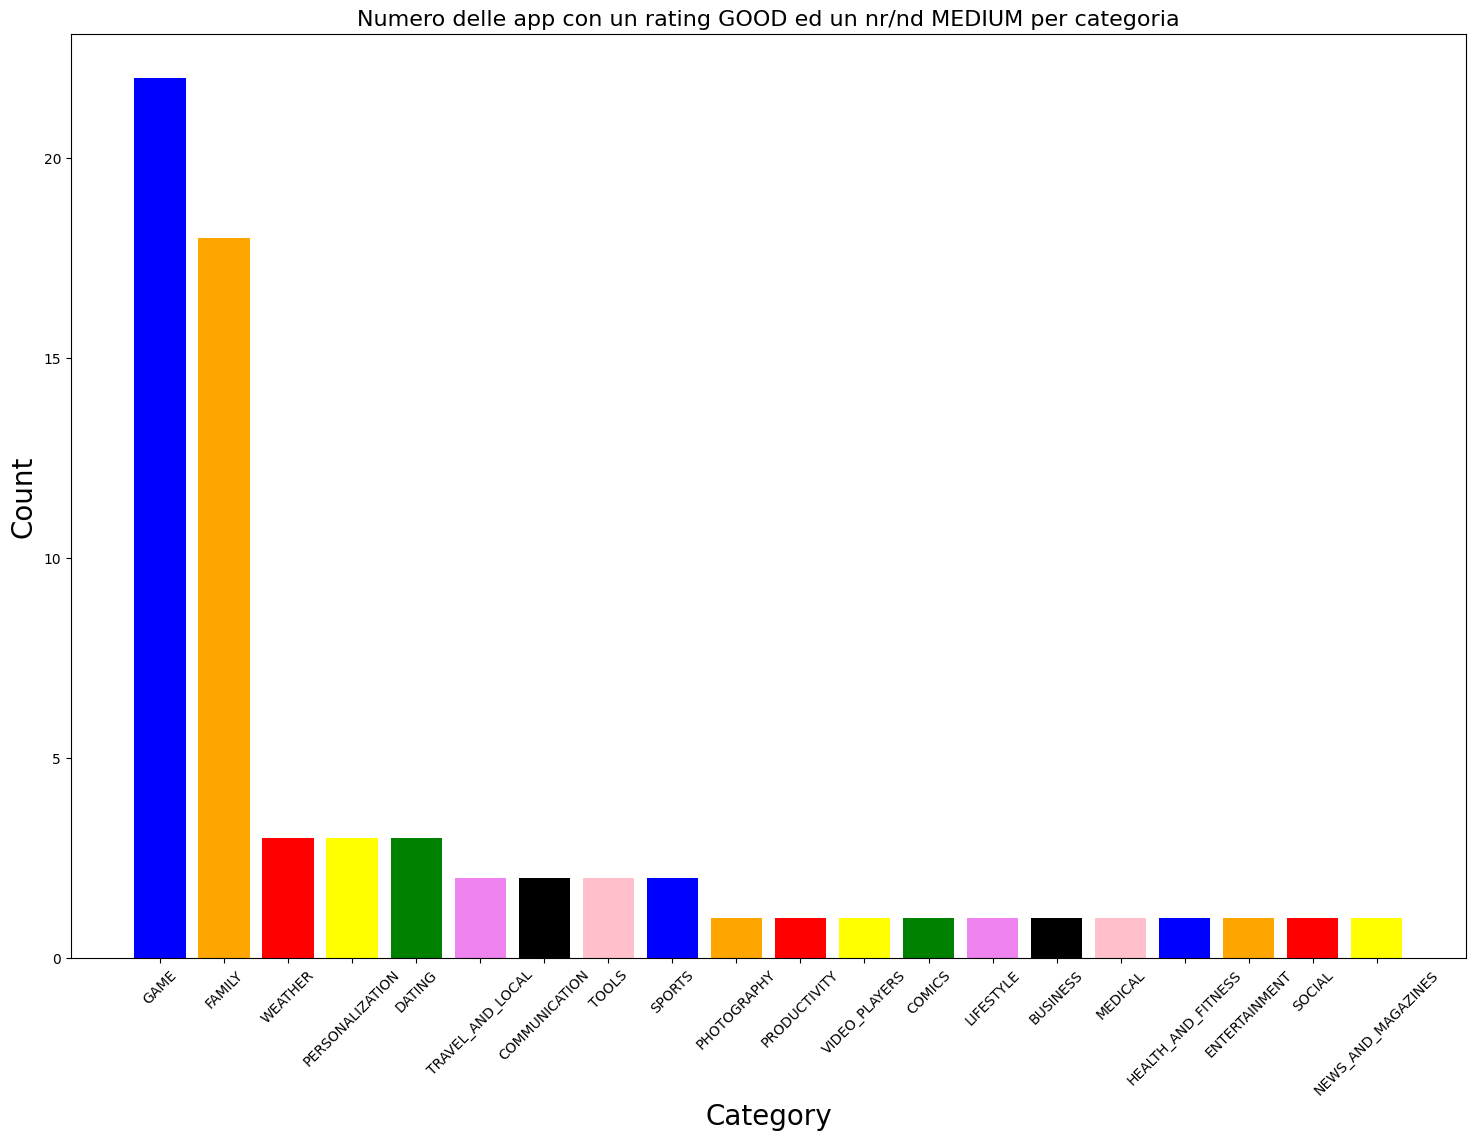

In [33]:
# Creiamo un bar plot con larghezza delle barre regolata
plt.figure(figsize=(18,12))  ## width, height
plt.bar(good_medium_apps_filtered['Category'], good_medium_apps_filtered['Count'], color=['blue', 'orange', 'red', 'yellow', 'green', 'violet', 'black', 'pink'], width=0.8)


# Impostiamo le etichette degli assi
plt.xlabel('Category', fontsize=20)
plt.ylabel('Count', fontsize=20)

# Impostiamo il titolo del grafico
plt.title('Numero delle app con un rating GOOD ed un nr/nd MEDIUM per categoria', fontsize=16)

# Impostiamo la dimensione del font per le etichette sull'asse x
plt.xticks(fontsize=10, rotation=45)

# Mostriamo il grafico
plt.show()

### Seconda visualizzazione OLAP proposta
Vogliamo cambiare il punto di vista dell'OLAP e concentrarci sulle differenze tra app free e paid

In [34]:
quantize_type = np.unique(playstore['Type'])
quantize_rating = ['BAD', 'SUFFICIENT', 'GOOD', 'EXCELLENT']
quantize_nr_nd = ['LOW', 'MEDIUM', 'HIGH']

playstore.loc[playstore['nr/nd'].between(0, 15), 'nr/nd_quant'] = quantize_nr_nd[0]
playstore.loc[playstore['nr/nd'].between(15, 35), 'nr/nd_quant'] = quantize_nr_nd[1]
playstore.loc[playstore['nr/nd'].between(35, 100), 'nr/nd_quant'] = quantize_nr_nd[2]

playstore.loc[playstore['Rating'] < 2.5, 'Rating_quant'] = quantize_rating[0]
playstore.loc[playstore['Rating'].between(2.5, 3.5), 'Rating_quant'] = quantize_rating[1]
playstore.loc[playstore['Rating'].between(3.6, 4.5), 'Rating_quant'] = quantize_rating[2]
playstore.loc[playstore['Rating'] >4.5, 'Rating_quant'] = quantize_rating[3]

results = pd.DataFrame(columns=['Type', 'Rating', 'nr/nd', 'Count'])
playstore['combined'] = playstore['Type'] + " / " + playstore['Rating_quant'] + " / " + playstore['nr/nd_quant']

counts = playstore['combined'].value_counts()

for z in range(0,len(quantize_type)):
    for j in range(0,len(quantize_rating)):
        for i in range(0,len(quantize_nr_nd)):
            key = f"{quantize_type[z]} / {quantize_rating[j]} / {quantize_nr_nd[i]}"
            #print("Key: ", key) # per vedere come si chiama la chiave (debug)
            count = counts.get(key, 0)
#Aggiungiamo i risultati al dataframe
            results.loc[len(results)] = [quantize_type[z], quantize_rating[j], quantize_nr_nd[i], count]
# printiamo il valore massimo di count
print("Massimo: ", results['Count'].max())
# ordiniamo il dataframe results in base alla colonna count
results = results.sort_values(by='Count', ascending=False)
results.head(24) # tutte le possibili combinazioni sono 24

Massimo:  4622


,Type,Rating,nr/nd,Count
6,Free,GOOD,LOW,4622
9,Free,EXCELLENT,LOW,921
3,Free,SUFFICIENT,LOW,504
18,Paid,GOOD,LOW,140
21,Paid,EXCELLENT,LOW,55
0,Free,BAD,LOW,45
19,Paid,GOOD,MEDIUM,36
10,Free,EXCELLENT,MEDIUM,33
7,Free,GOOD,MEDIUM,32
22,Paid,EXCELLENT,MEDIUM,28


Da questa visualizzazione possiamo notare che
* lo store è dominato da applicazioni che hanno un nr/nd basso
* il numero di app a pagamento è molto più piccolo rispetto al numero di app free
* generalmente le recensioni positive sono più comuni di quelle negative

Proviamo a visualizzare queste informazioni con qualche grafico:

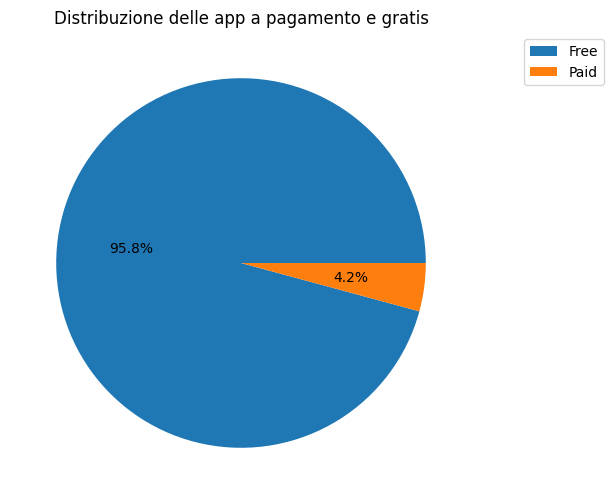

In [35]:
# grafico a torta per vedere la distribuzione delle app free/paid:
playstore['Type'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6), labels=None)
plt.ylabel('')
plt.title('Distribuzione delle app a pagamento e gratis')
plt.legend(labels=playstore['Type'].value_counts().index, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


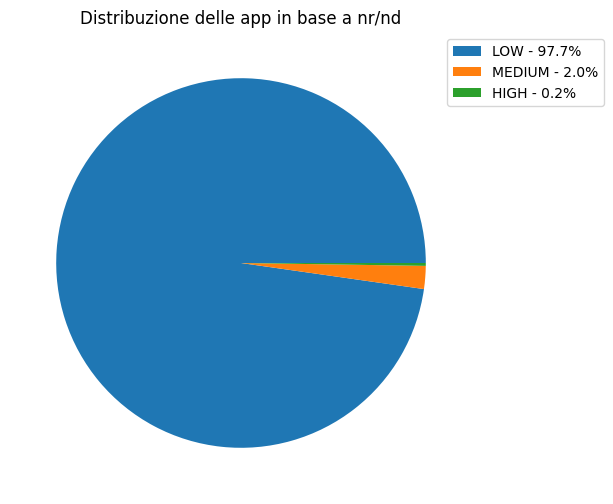

In [36]:
percentages = (playstore['nr/nd_quant'].value_counts() / len(playstore)) * 100
labels = [f'{label} - {percentage:.1f}%' for label, percentage in zip(percentages.index, percentages)]

# Plot del grafico a torta
playstore['nr/nd_quant'].value_counts().plot.pie(autopct='', figsize=(6,6), labels=None)
plt.ylabel('')
plt.title('Distribuzione delle app in base a nr/nd')
plt.legend(labels=labels, loc='upper right', bbox_to_anchor=(1.3, 1))
# Mostra il grafico
plt.show()

In [37]:
low_results = results.loc[results['nr/nd'] == 'LOW']
medium_results = results.loc[results['nr/nd'] == 'MEDIUM']
high_results = results.loc[results['nr/nd'] == 'HIGH']

In [38]:
custom_rating_order = ['BAD', 'SUFFICIENT', 'GOOD', 'EXCELLENT']

# Crea una copia esplicita del DataFrame per evitare il SettingWithCopyWarning
low_results_copy = low_results.copy()
medium_results_copy = medium_results.copy()
high_results_copy = high_results.copy()

# Modifica il Rating nel DataFrame copiato
low_results_copy['Rating'] = pd.Categorical(low_results_copy['Rating'], categories=custom_rating_order, ordered=True)
low_results_copy = low_results_copy.sort_values('Rating')
low_results=low_results_copy


medium_results_copy['Rating'] = pd.Categorical(medium_results_copy['Rating'], categories=custom_rating_order, ordered=True)
medium_results_copy = medium_results_copy.sort_values('Rating')
medium_results=medium_results_copy

high_results_copy['Rating'] = pd.Categorical(high_results_copy['Rating'], categories=custom_rating_order, ordered=True)
high_results_copy = high_results_copy.sort_values('Rating')
high_results=high_results_copy

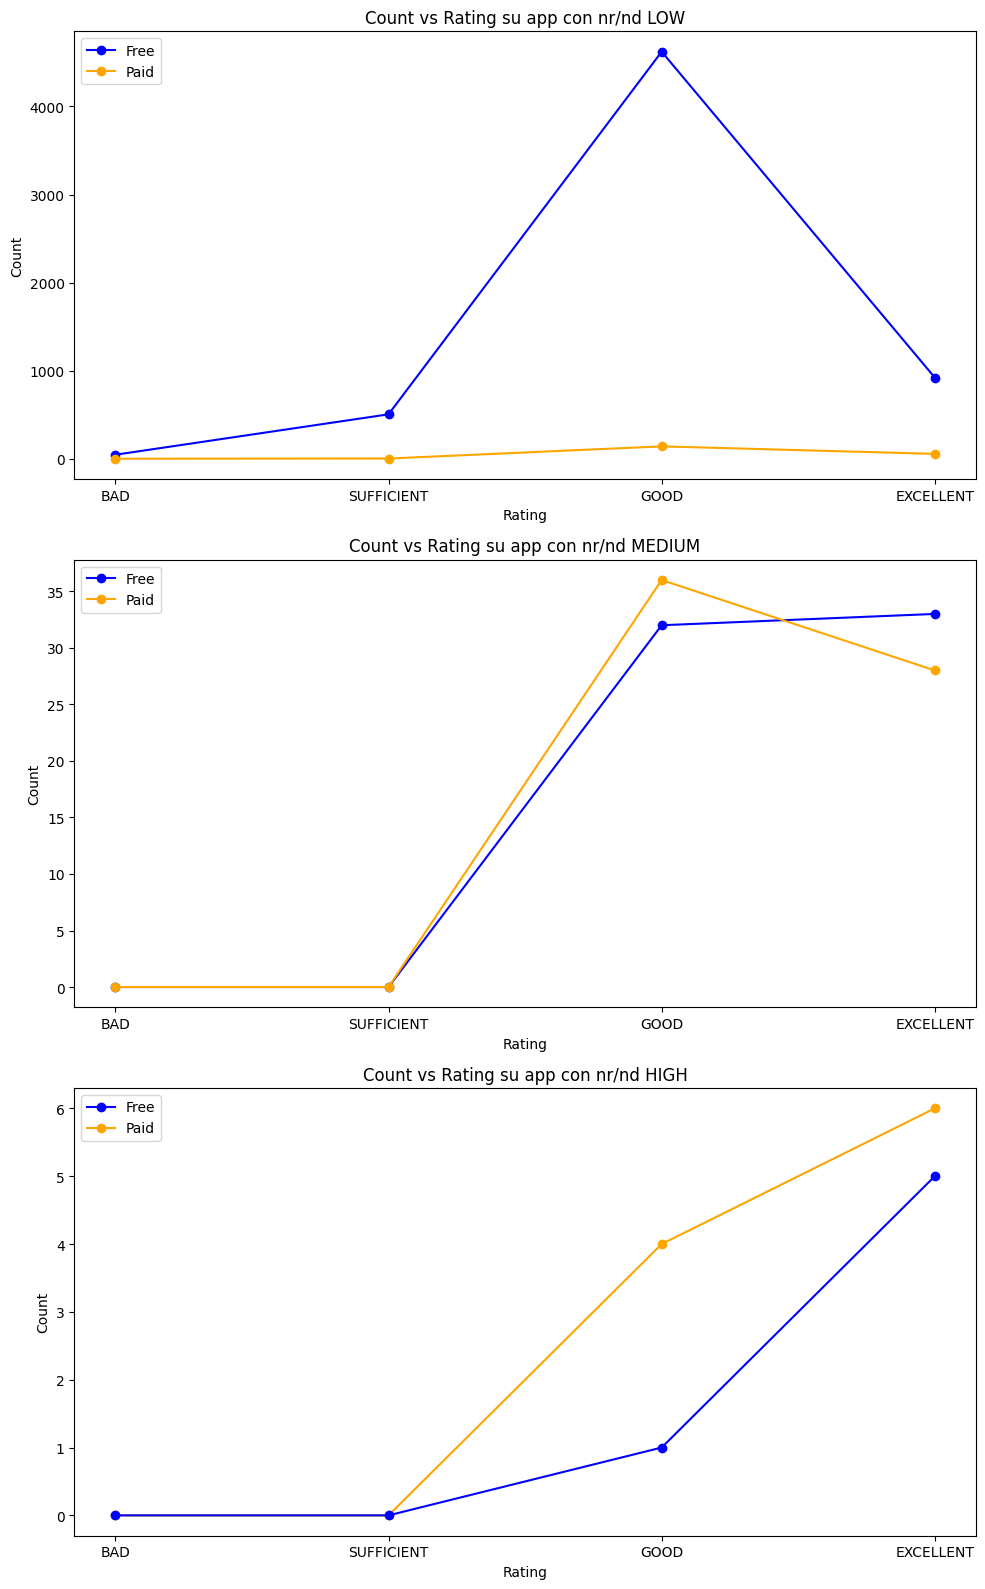

In [39]:
import matplotlib.pyplot as plt
# Crea una nuova figura
plt.figure(figsize=(10, 16))

colors = {'Free': 'blue', 'Paid': 'orange'}


# Plot per LOW
plt.subplot(3, 1, 1)  # 3 righe, 1 colonna, subplot 1
for type in low_results['Type'].unique():
    subset = low_results[low_results['Type'] == type]
    plt.plot(subset['Rating'], subset['Count'], marker='o', label=type, color=colors.get(type, 'black'))
plt.title('Count vs Rating su app con nr/nd LOW')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(loc='upper left')

# Plot per MEDIUM
plt.subplot(3, 1, 2)  # 3 righe, 1 colonna, subplot 2
for type in medium_results['Type'].unique():
    subset = medium_results[medium_results['Type'] == type]
    plt.plot(subset['Rating'], subset['Count'], marker='o', label=type,color=colors.get(type, 'black'))
plt.title('Count vs Rating su app con nr/nd MEDIUM')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(loc='upper left')

# Plot per HIGH
plt.subplot(3, 1, 3)  # 3 righe, 1 colonna, subplot 3
for type in high_results['Type'].unique():
    subset = high_results[high_results['Type'] == type]
    plt.plot(subset['Rating'], subset['Count'], marker='o', label=type,color=colors.get(type, 'black'))
plt.title('Count vs Rating su app con nr/nd HIGH')
plt.xlabel('Rating')
plt.ylabel('Count')
handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,0] #non so perché mi invertiva l'ordine solo in questo grafico, quindi l'ho re-invertito per consistency
plt.legend([handles[i] for i in order], [labels[i] for i in order]) 


# Imposta lo spazio tra i grafici
plt.tight_layout()

# Mostra il grafico
plt.show()


Da questi ultimi grafici notiamo che, per quanto riguarda le app con nr/nd basso e medio la valutazione è sempre per lo più buona, mentre, se esaminiamo quelle con nr/nd alto, la valutazione maggioritaria è eccellente, sia per le app free che quelle a pagamento.
<br>
Un'altra cosa importante da notare è che la spezzata delle app free sta sempre sopra o al limite coincide con quella delle app a pagamento per quanto riguarda lo slicing su LOW, mentre nel caso delle app con nr/nd MEDIUM questa tendenza si inverte sulle app valutate GOOD, ciò significa che in questo caso, ci sono più app considerate buone a pagamento che gratis, mentre però, come osserviamo, ci sono più app eccellenti gratis che a pagamento. Questo vale anche per lo slicing su HIGH, dove interessa anche le app eccellenti, quindi possiamo dire che ci sono più app eccellenti a pagamento rispetto che app eccellenti gratis e più app buone a pagamento piuttosto che app buone gratis se stiamo considerando app con un nr/nd alto.

## Test Statistico
Dopo aver condotto l'analisi, abbiamo identificato la categoria "game" come quella con il valore più elevato di nr/nd.
Presumiamo che, in questa categoria, saranno le applicazioni a pagamento ad avere l'nr-nd più alto. Questa supposizione si basa sul ragionamento che gli utenti che pagano per un'applicazione sono probabilmente più inclini a lasciare recensioni e quindi dare una valutazione, positiva o negativa che sia, all'applicazione. Questo perché l'atto di acquisto potrebbe indicare un maggiore coinvolgimento o aspettative più elevate da parte dell'utente rispetto alle app gratuite.

In [40]:
#Creiamo un dataframe per la categoria game:
game = playstore[playstore['Category'] == 'GAME']
#Contiamo quante app sono a pagamento e quante sono gratuite:
game['Type'].value_counts()


Type
Free    780
Paid     48
Name: count, dtype: int64

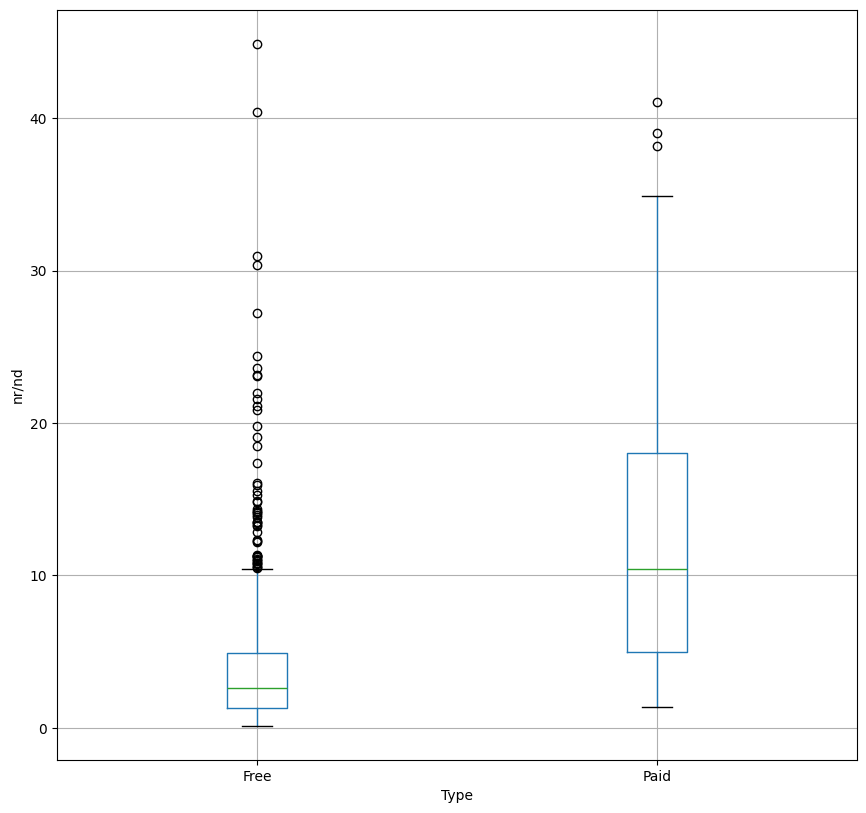

In [41]:
#visualizziamo un boxplot per confrontare le due distribuzioni e farci una idea:
game.boxplot(column='nr/nd', by='Type', figsize=(10,10))
plt.ylabel('nr/nd')
plt.title('')
plt.suptitle('')
plt.show()

Scegliamo un livello di significatività di 0.05 e consideriamo le seguenti ipotesi:
* ipotesi nulla H0 = le medie di nr/nd delle app free e di quelle paid **non** sono statisticamente diverse
* ipotesi alternativa HA = le medie sono diverse

In [42]:
#Testiamo se le due distribuzioni sono significativamente diverse:
t_stat, p_value=stats.ttest_ind(game[game['Type'] == 'Free']['nr/nd'], game[game['Type'] == 'Paid']['nr/nd'])
print("p value",p_value)

p value 5.306353683974098e-33


Il p-value è molto basso, e, siccome p-value << livello di significatività, possiamo concludere che le due distribuzioni sono significativamente diverse (rigettando l'ipotesi nulla in favore di quella alternativa).

Verifichiamo ora che la media del nr/nd delle app free sia più bassa rispetto a quella delle app paid.
Usiamo il t-test ad una coda. Scegliamo un livello di significatività di 0.05.
* ipotesi nulla H0 = la media di nr/nd delle app free è inferiore rispetto a quella delle app paid
* ipotesi alternativa HA = la media di nr/nd delle app free è maggiore o uguale rispetto a quella delle app paid

In [43]:
# Eseguiamo il t-test ad una coda con direzione positiva per vedere se le app a pagamento hanno un rapporto recensioni/installazioni maggiore:
t_stat, p_value=stats.ttest_ind(game[game['Type'] == 'Free']['nr/nd'], game[game['Type'] == 'Paid']['nr/nd'], alternative='greater')
print("p value",p_value)

p value 1.0


e facciamo anche una ultima prova come sanity check, verificando l'alternativa rimasta.

In [44]:
#eseguiamo il t-test ad una coda con direzione negativa
t_stat, p_value=stats.ttest_ind(game[game['Type'] == 'Free']['nr/nd'], game[game['Type'] == 'Paid']['nr/nd'], alternative='less')
print("p value",p_value)

p value 2.653176841987049e-33


siccome il p-value è **molto** più piccolo di 0.05 possiamo rifiutare l'ipotesi nulla, secondo cui media(free) non è inferiore di media(paid), a favore di quella alternativa, secondo cui media(free) è inferiore rispetto a media(paid) 

proviamo a confrontare le due medie su un grafico a barre, confermando che il risultato del t-test sia sensato

In [45]:
# Suddividere il dataframe in due sottoinsiemi basati sul tipo di app (Paid o Free) all'interno della categoria GAME

paid_games = game[game['Type'] == 'Paid']
free_games = game[game['Type'] == 'Free']

# Calcolare la media del rapporto nr/nd per entrambi i sottoinsiemi
mean_nrnd_paid = paid_games['nr/nd'].mean()
mean_nrnd_free = free_games['nr/nd'].mean()

# Confrontare le medie per determinare se le app a pagamento o quelle gratuite hanno un nr/nd più alto
if mean_nrnd_paid > mean_nrnd_free:
    print("Le app a pagamento hanno un nr/nd più alto nella categoria GAME.")
elif mean_nrnd_paid < mean_nrnd_free:
    print("Le app gratuite hanno un nr/nd più alto nella categoria GAME.")
else:
    print("Non c'è differenza significativa tra il nr/nd delle app a pagamento e quello delle app gratuite nella categoria GAME.")
print("Media nr/nd per app a pagamento:", mean_nrnd_paid)
print("Media nr/nd per app gratuite:", mean_nrnd_free)

Le app a pagamento hanno un nr/nd più alto nella categoria GAME.
Media nr/nd per app a pagamento: 13.403169166666666
Media nr/nd per app gratuite: 3.9806367561538454


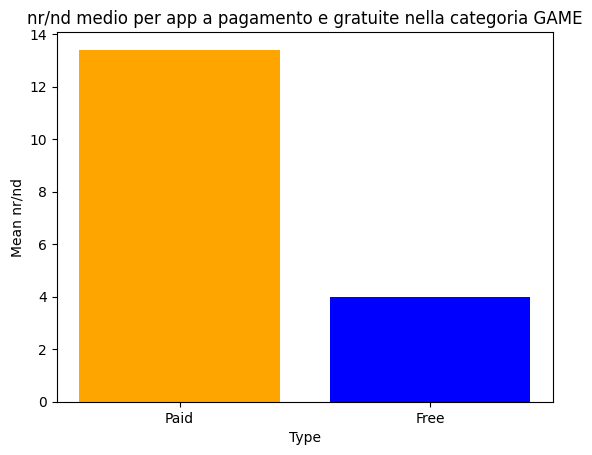

In [46]:
# visualizziamo questa informazione in un grafico a barre:
plt.bar(['Paid', 'Free'], [mean_nrnd_paid, mean_nrnd_free], color=['orange', 'blue'])
plt.xlabel('Type')
plt.ylabel('Mean nr/nd')
plt.title('nr/nd medio per app a pagamento e gratuite nella categoria GAME')
plt.show()

Attraverso questi test statistici abbiamo dunque verificato che, per quanto riguarda la categoria GAME, c'è una differenza statisticamente significativa in termini di numero di recensioni/numero di installazioni tra app a pagamento e app gratuite, confermando la nostra iniziale ipotesi secondo cui quelle a pagamento avrebbero performato meglio per quanto riguarda questa metrica.

Adesso ci interessa sapere se questo rimane vero anche per tutto lo store in generale, o se è circoscritto ai soli giochi

scegliamo un livello di significatività di 0.05 e consideriamo le seguenti ipotesi:
* ipotesi nulla H0 = le medie di nr/nd delle app free e di quelle paid non sono statisticamente diverse
* ipotesi alternativa HA = le medie sono diverse

In [47]:
paid = playstore[playstore['Type'] == 'Paid']
free = playstore[playstore['Type'] == 'Free']
#testiamo se le due distribuzioni sono significativamente diverse
t_stat, p_value=stats.ttest_ind(paid['nr/nd'], free['nr/nd'])
print(p_value)

1.105897418864478e-243


Il p-value è molto basso, e, siccome p-value << livello di significatività, possiamo concludere che le due distribuzioni sono significativamente diverse (rigettando l'ipotesi nulla in favore di quella alternativa).<br>
Verifichiamo ora che la media del nr/nd delle app free sia più bassa rispetto a quella delle app paid. Usiamo il t-test ad una coda. Scegliamo un livello di significatività di 0.05.
* ipotesi nulla H0 = la media di nr/nd delle app free è inferiore rispetto a quella delle app paid
* ipotesi alternativa HA = la media di nr/nd delle app free è maggiore o uguale rispetto a quella delle app paid

In [76]:
# Eseguiamo il t-test ad una coda con direzione positiva per vedere se le app a pagamento hanno un rapporto recensioni/installazioni maggiore:
t_stat, p_value=stats.ttest_ind(free['nr/nd'], paid['nr/nd'], alternative='greater')
print("p value",p_value)

p value 1.0


e facciamo anche una ultima prova come sanity check, verificando l'alternativa rimasta.

In [77]:
#eseguiamo il t-test ad una coda con direzione negativa
t_stat, p_value=stats.ttest_ind(free['nr/nd'], paid['nr/nd'], alternative='less')
print("p value",p_value)


p value 5.52948709432239e-244


siccome il p-value è molto più piccolo di 0.05 possiamo rifiutare l'ipotesi nulla, secondo cui media(free) non è inferiore di media(paid), a favore di quella alternativa, secondo cui media(free) è inferiore rispetto a media(paid)

confrontiamo anche in questo caso le due medie su un grafico a barre, confermando il risultato del test statistico.

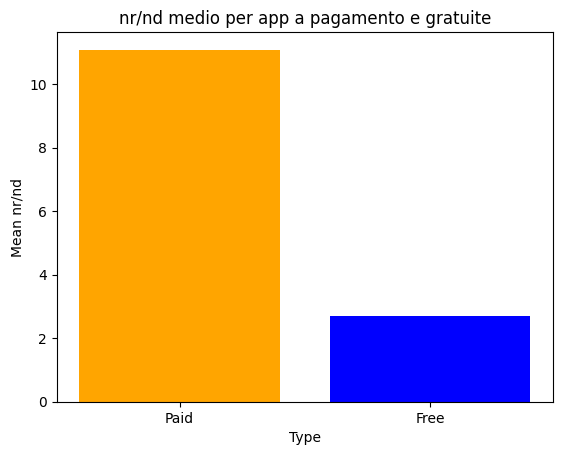

In [48]:
mean_nrnd_paid = paid['nr/nd'].mean()
mean_nrnd_free = free['nr/nd'].mean()

plt.bar(['Paid', 'Free'], [mean_nrnd_paid, mean_nrnd_free], color=['orange', 'blue'])
plt.xlabel('Type')
plt.ylabel('Mean nr/nd')
plt.title('nr/nd medio per app a pagamento e gratuite')
plt.show()

## Metodo predittivo
Utilizziamo una rappresentazione grafica per verificare se le due features (nr/nd e rating) siano correlate, e se sia quindi possibile utilizzare una di queste features per predire l'altra.

Text(0, 0.5, 'Rating')

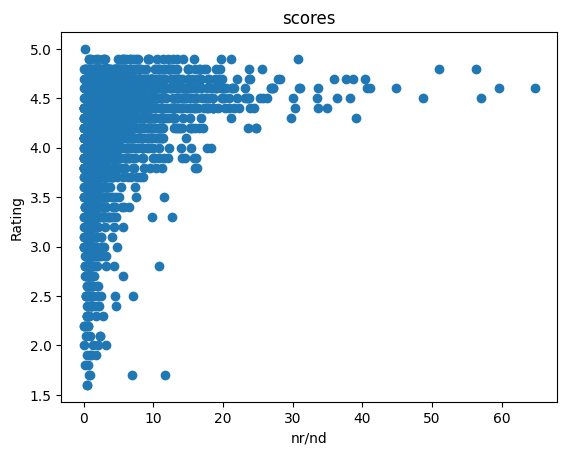

In [49]:
plt.scatter(playstore['nr/nd'], playstore['Rating'])
plt.title('scores')
plt.xlabel('nr/nd')
plt.ylabel('Rating')

Verifichiamo la correlazione attraverso il coefficiente di correlazione di Pearson (r).

In [50]:
correlation, p_value = stats.pearsonr(playstore['nr/nd'],playstore['Rating'])
print("Coefficiente di Pearson: ", correlation)


Coefficiente di Pearson:  0.2723173747155313


### Terza ipotesi smentita
In fase preliminare avevamo pensato che, al crescere di una metrica, sarebbe diminuita l'altra, mentre, da quanto si evince dal calcolo del coefficiente di Pearson, c'è una correlazione positiva (anche se non particolarmente significativa) e non negativa tra le due variabili.

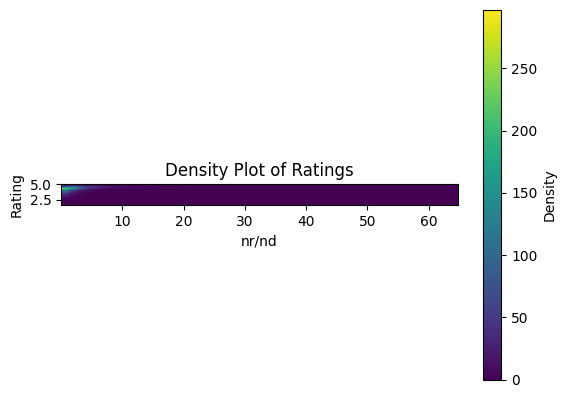

In [51]:
# Calcoliamo una rappresentazione a griglia della densità dei punti
x = playstore['nr/nd']
y = playstore['Rating']
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plottiamo il grafico a dispersione in falsi colori
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Density')
plt.title('Density Plot of Ratings')
plt.xlabel('nr/nd')
plt.ylabel('Rating')
plt.show()

Notiamo anche in questo grafico una predominanza di rating alti

In [52]:
#diamo un'occhiata alla distribuzione della colonna rating
playstore['Rating'].describe()

count    6434.000000
mean        4.178007
std         0.438951
min         1.600000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

In [53]:
moda = playstore['Rating'].mode()

moda_valore = moda[0] if not moda.empty else None

print("La moda è:", moda_valore)


La moda è: 4.3


### Distribuzione del Rating
Effettivamente vediamo che la media è 4.17 e che c'è una deviazione standard di 0.4, quindi intuiamo che la grande maggioranza delle app che stiamo analizzando hanno un rating che sta sulla fascia del 4/4.5. Calcolando la moda vediamo inoltre che il valore più frequente per il rating è 4.3.<br>
Tutte queste informazioni potrebbero suggerire che, se qualcuno lascia una recensione, in generale è per esprimere una opinione positiva (come vediamo, la distribuzione dei rating è sbilanciata sulla fascia medio-alta)

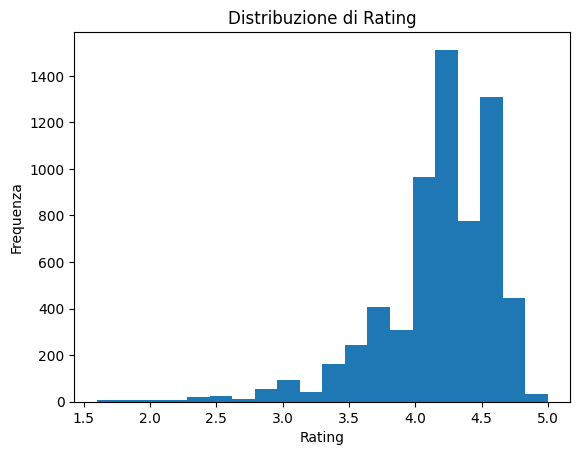

In [54]:
plt.hist(playstore['Rating'], bins=20)
plt.xlabel('Rating')
plt.ylabel('Frequenza')
plt.title('Distribuzione di Rating' )
plt.show()

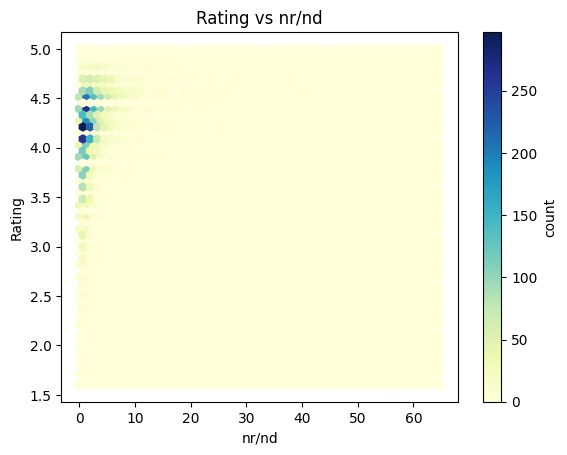

In [55]:
#Plottiamo in falsi color con un hexbin plot:
plt.hexbin(playstore['nr/nd'], playstore['Rating'], gridsize=50, cmap='YlGnBu')
plt.xlabel('nr/nd')
plt.ylabel('Rating')
plt.title('Rating vs nr/nd')
plt.colorbar(label='count')
plt.show()

In [56]:
from sklearn.model_selection import train_test_split
#codice qui 
# Definiamo le caratteristiche da usare
X = playstore[['nr/nd']] #nr/nd sarà il nostro predittore
y = playstore['Rating'] #Rating sarà la variabile da predire (target)

# Dividiamo il dataset in training set e validation set usando la proporzione 70/30
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
from sklearn.linear_model import LinearRegression
# Istanziamo l'oggetto della classe LinearRegression
regressor = LinearRegression()

# Alleniamo il modello passando il training set
regressor.fit(X_train, y_train)

# Visualizziamo i coefficienti imparati
print("Intercept:", regressor.intercept_)
print("Coefficiente nr/nd", regressor.coef_[0]) 


Intercept: 4.092397682955053
Coefficiente nr/nd 0.02825438802545882


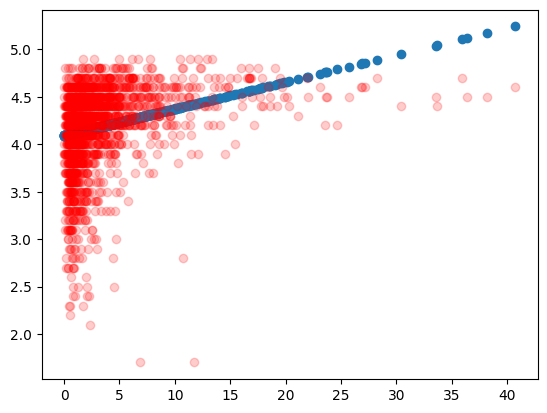

In [58]:
y_hat =regressor.predict(X_valid)

plt.scatter(X_valid,y_hat)
plt.scatter(X_valid,y_valid,c='r',alpha=0.2)

### Usiamo le tre stime per capire quanto precisa è la funzione imparata


In [59]:
import sklearn.metrics as metrics 
y_pred = regressor.predict(X_valid)
print ('MAE:', metrics.mean_absolute_error(y_valid, y_pred))
print ('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

MAE: 0.31013517872291907
MSE: 0.17648797763986968
RMSE: 0.4201047222299098


### Determiniamo il modello nullo e confrontiamo le metriche appena ottenute

In [60]:
def MSE (y_pred,y_true):
    #errore quadratico medio
    mse = np.mean((y_pred - y_true) ** 2)
    return mse 

def MAE (y_pred,y_true):
    #scarto medio assoluto
    mae = np.mean(np.abs(y_pred - y_true))
    return mae


def RMSE (y_pred,y_true):
    #radice quadrata dell'errore quadratico medio
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return rmse


# calcoliamo il nr/nd medio
mean_nr_nd = playstore['nr/nd'].mean()
# creiamo la nuova x con lo stesso numero di campioni del validation set originale, e con tutti i valori uguali a mean_nr_nd appena calcolato
null_model = [mean_nr_nd] * y_valid.shape[0]

null_mae = MAE(null_model, y_valid)
null_mse = MSE(null_model, y_valid)
null_rmse = RMSE(null_model, y_valid)

#stampate gli errori
print("Scarto medio assoluto (MAE):", null_mae)
print("Errore quadratico medio (MSE):", null_mse)
print("Radice dell'errore quadratico medio (RMSE):", null_rmse)

Scarto medio assoluto (MAE): 1.150975063320676
Errore quadratico medio (MSE): 1.4723934776169305
Radice dell'errore quadratico medio (RMSE): 1.2134222173740394


### Considerazioni
Possiamo dire quindi che il modello sta imparando, ma non riporta risultati troppo sorprendenti, è sicuramente però migliore del modello nullo, in quanto, sia lo scarto medio assoluto che l'errore quadratico medio che la radice dell'errore quadratico medio sono minori rispetto a quelli ottenuti con il modello nullo.

In [61]:
playstore.info() #visualizziamo la struttura del dataset prima di effettuare clustering

<class 'pandas.core.frame.DataFrame'>
Index: 6434 entries, 7165 to 3268
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   App           6434 non-null   object 
 1   Category      6434 non-null   object 
 2   Rating        6434 non-null   float64
 3   Reviews       6434 non-null   int64  
 4   Installs      6434 non-null   int64  
 5   Type          6434 non-null   object 
 6   nr/nd         6434 non-null   float64
 7   nr/nd_quant   6434 non-null   object 
 8   Rating_quant  6434 non-null   object 
 9   combined      6434 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 552.9+ KB


## Clustering
Innanzitutto calcoliamo e plottiamo il coefficiente di silhouette per ogni k da 2 a 10

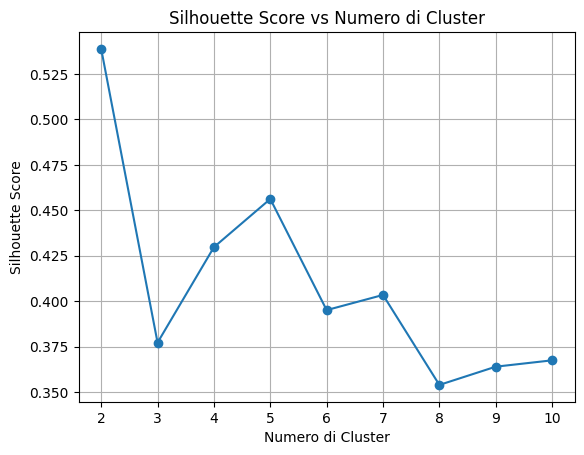

In [62]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
X = playstore[['Rating', 'nr/nd', 'Installs', 'Reviews']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Lista dei numeri di cluster da testare
num_clusters = range(2, 11)  # Possiamo testare da 2 a 10 cluster

# Lista per memorizzare i coefficienti di silhouette corrispondenti a ciascun numero di cluster
silhouette_scores = []

# Calcola il coefficiente di silhouette per ciascun numero di cluster
for n_clusters in num_clusters:
    model = KMeans(n_clusters=n_clusters, random_state=42)
    model.fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, model.labels_)
    silhouette_scores.append(silhouette_avg)

# Traccia il grafico
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Numero di Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Numero di Cluster')
plt.xticks(num_clusters)
plt.grid(True)
plt.show()


Scegliamo k=5 perché sembra essere quello con silhouette migliore (oltre al 2 che è abbastanza scontato)

In [63]:
#Facciamo un esempio di clustering con i dati a disposizione:

#Addestriamo il modello di clustering:
model = KMeans(n_clusters=5, random_state=42)
model.fit(X_scaled)

#Aggiungiamo le predizioni al dataset:
playstore['Cluster'] = model.predict(X_scaled)

# Visualizziamo il numero di app per cluster
playstore['Cluster'].value_counts()

# Visualizziamo le statistiche per ogni cluster
playstore.groupby('Cluster').describe()

Rating                                                Reviews  \
          count      mean       std  min  25%  50%    75%  max   count   
Cluster                                                                  
0        3736.0  4.421226  0.167145  4.1  4.3  4.4  4.500  5.0  3736.0   
1         436.0  3.023165  0.395771  1.6  2.9  3.1  3.300  3.4   436.0   
2         314.0  4.535032  0.207022  3.8  4.4  4.6  4.700  4.9   314.0   
3        1904.0  3.903466  0.184726  3.5  3.8  4.0  4.100  4.1  1904.0   
4          44.0  4.302273  0.214030  3.7  4.2  4.3  4.425  4.7    44.0   

                       ...      Installs                 nr/nd             \
                 mean  ...           75%           max   count       mean   
Cluster                ...                                                  
0        2.811636e+05  ...  1.000000e+07  1.000000e+08  3736.0   2.751850   
1        7.940697e+03  ...  5.000000e+05  5.000000e+07   436.0   1.281267   
2        9.974535e+05  ...  1.000000e+06  1.000000e+08   314.0  17.092086   
3        4.631100e+04  ...  1.000000e+06  1.000000e+08  1904.0   1.740103   
4        1.447006e+07  ...  1.000000e+09  1.000000e+09    44.0   1.984402   

                                                                         
              std       min        25%        50%        75%        max  
Cluster                                                                  
0        2.175780  0.009602   1.090000   2.092550   3.874725  10.749700  
1        1.469292  0.000660   0.490000   0.847000   1.487000  12.610000  
2        8.623918  9.227520  11.562550  14.528160  18.810750  64.770000  
3        1.770814  0.015368   0.641230   1.170000   2.180250  14.170000  
4        2.241867  0.056492   0.372152   1.067136   2.617204   8.583305  

[5 rows x 32 columns]

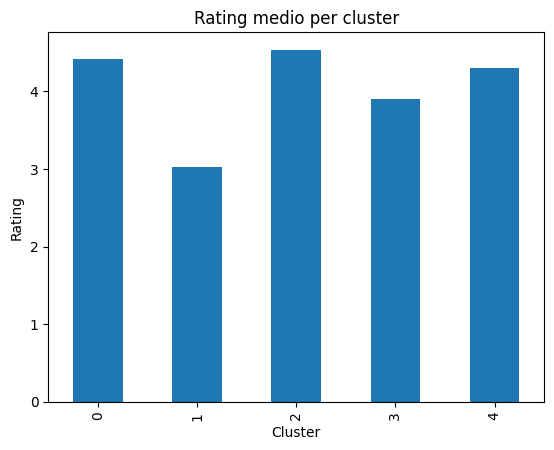

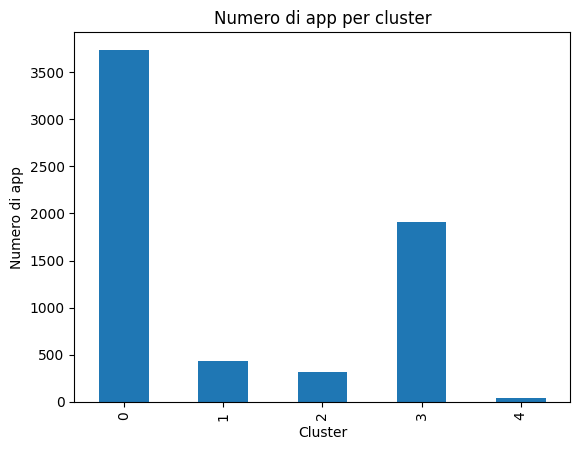

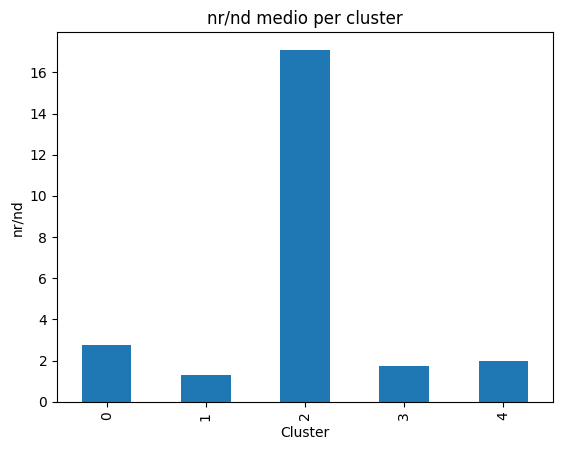

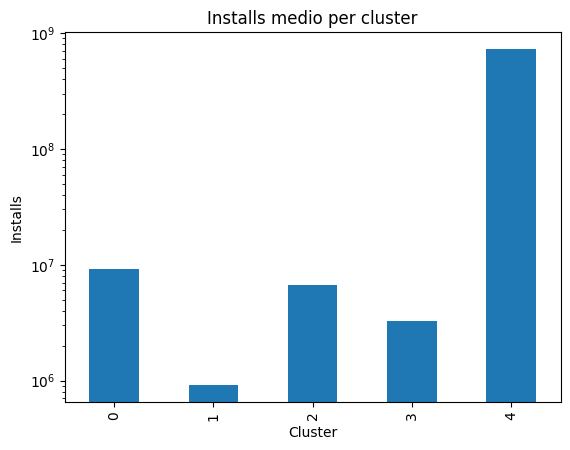

In [64]:
# visualizziamo come sono distribuiti i cluster rispetto alla colonna 'Rating':
playstore.groupby('Cluster')['Rating'].mean().plot.bar()
plt.ylabel('Rating')
plt.title('Rating medio per cluster')
plt.show()
# visualizziamo quante app ci sono per ogni cluster:
# Calcolare il conteggio delle app per ogni cluster e ordinarlo
conteggi_ordinati = playstore['Cluster'].value_counts().sort_index()  # Usa sort_values() per ordinare per conteggio

# Creare il grafico a barre utilizzando i conteggi ordinati
conteggi_ordinati.plot.bar()
plt.ylabel('Numero di app')
plt.title('Numero di app per cluster')
plt.show()

# visualizziamo come sono distribuiti i cluster rispetto alla colonna 'nr/nd':
playstore.groupby('Cluster')['nr/nd'].mean().plot.bar()
plt.ylabel('nr/nd')
plt.title('nr/nd medio per cluster')
plt.show()

# visualizziamo come sono distribuiti i cluster rispetto alla colonna 'Installs':
playstore.groupby('Cluster')['Installs'].mean().plot.bar()
plt.ylabel('Installs')
plt.title('Installs medio per cluster')
plt.yscale('log')  
plt.show()

In [65]:
# controlliamo, per ogni cluster, quante app hanno un rating 'BAD'
for i in range(5):
    print("Cluster", i, ":", playstore[(playstore['Cluster'] == i) & (playstore['Rating_quant'] == 'BAD')].shape[0])

Cluster 0 : 0
Cluster 1 : 45
Cluster 2 : 0
Cluster 3 : 0
Cluster 4 : 0


### Considerazioni sul clustering 
analizzando brevemente i risultati del clustering notiamo che c'è solo un cluster con valutazioni negative (BAD), e questo è il cluster 1. Quindi tutte le app con un rating medio <2.5 sono finite in un solo cluster.
Altra cosa che notiamo subito è che il cluster 4 è quello con l'install medio più alto...dando un'occhiata a questo cluster non ci viene difficile capire perché:


In [66]:
print(playstore[playstore['Cluster']==4].describe())
playstore[playstore['Cluster']==4].head(50)

          Rating       Reviews      Installs      nr/nd  Cluster
count  44.000000  4.400000e+01  4.400000e+01  44.000000     44.0
mean    4.302273  1.447006e+07  7.272727e+08   1.984402      4.0
std     0.214030  1.924899e+07  2.518431e+08   2.241867      0.0
min     3.700000  2.824600e+05  5.000000e+08   0.056492      4.0
25%     4.200000  2.118298e+06  5.000000e+08   0.372152      4.0
50%     4.300000  8.076051e+06  5.000000e+08   1.067136      4.0
75%     4.425000  1.542211e+07  1.000000e+09   2.617204      4.0
max     4.700000  7.815831e+07  1.000000e+09   8.583305      4.0


,App,Category,Rating,Reviews,Installs,Type,nr/nd,nr/nd_quant,Rating_quant,combined,Cluster
4005,Clean Master- Space Cleaner & Antivirus,TOOLS,4.7,42916526,500000000,Free,8.583305,LOW,EXCELLENT,Free / EXCELLENT / LOW,4
2544,Facebook,SOCIAL,4.1,78158306,1000000000,Free,7.815831,LOW,GOOD,Free / GOOD / LOW,4
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,1000000000,Free,6.911932,LOW,GOOD,Free / GOOD / LOW,4
2545,Instagram,SOCIAL,4.5,66577313,1000000000,Free,6.657731,LOW,GOOD,Free / GOOD / LOW,4
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,1000000000,Free,5.664285,LOW,GOOD,Free / GOOD / LOW,4
7536,"Security Master - Antivirus, VPN, AppLock, Boo...",TOOLS,4.7,24900999,500000000,Free,4.980200,LOW,EXCELLENT,Free / EXCELLENT / LOW,4
1655,Candy Crush Saga,GAME,4.4,22426677,500000000,Free,4.485335,LOW,GOOD,Free / GOOD / LOW,4
378,UC Browser - Fast Download Private & Secure,COMMUNICATION,4.5,17712922,500000000,Free,3.542584,LOW,GOOD,Free / GOOD / LOW,4
2550,Snapchat,SOCIAL,4.0,17014787,500000000,Free,3.402957,LOW,GOOD,Free / GOOD / LOW,4
1722,My Talking Tom,GAME,4.5,14891223,500000000,Free,2.978245,LOW,GOOD,Free / GOOD / LOW,4


dentro questo cluster sono finite praticamente tutte le "BIG" dello store, troviamo Google Drive, Skype, l'app di Google, Snapchat, YouTube e addirittura Subway Surfers e Candy Crush Saga, per non parlare di Instagram ed infine Messenger, l'app più scaricata (oltre a quelle già preinstallate su tutti i dispositivi Android) di tutto lo store.
Ci sembra plausibile che questo cluster abbia l'install rate medio più alto, contenendo le app con il numero di installazioni più alto ed essendo composto da solo 44 app.

In [67]:
# visualizziamo il dataset ordinandolo in base ad Installs:
print(playstore.sort_values(by='Installs', ascending=False)['App'].head(50))

3117                            Maps - Navigate & Explore
341                                              Hangouts
152                                     Google Play Books
335              Messenger – Text and Video Chat for Free
3234                                               Google
3687                              Google Play Movies & TV
3736                                          Google News
3127                                   Google Street View
2545                                            Instagram
2808                                        Google Photos
2544                                             Facebook
3454                                         Google Drive
865                                     Google Play Games
338                          Google Chrome: Fast & Secure
1654                                       Subway Surfers
391                         Skype - free IM & video calls
2554                                              Google+
336           

In [68]:
# controlliamo se esistono app con 500000000 installs in altri cluster:
print(playstore[(playstore['Installs'] >= 500000000) & (playstore['Cluster'] != 4)])

Empty DataFrame
Columns: [App, Category, Rating, Reviews, Installs, Type, nr/nd, nr/nd_quant, Rating_quant, combined, Cluster]
Index: []


come vediamo, tutte le app con 500 milioni di download o più sono state inserite nel cluster 4.

In [69]:
print(playstore[playstore['App']=='Clash of Clans'])

                 App Category  Rating   Reviews   Installs  Type      nr/nd  \
1670  Clash of Clans     GAME     4.6  44891723  100000000  Free  44.891723   

     nr/nd_quant Rating_quant                 combined  Cluster  
1670        HIGH    EXCELLENT  Free / EXCELLENT / HIGH        2  


In [70]:
#visualizziamo il cluster 2, siccome è quello con il nr/nd medio più alto
print(playstore[playstore['Cluster']==2].head(50))

                                                  App             Category  \
7165    My Movies Pro - Movie & TV Collection Library            LIFESTYLE   
9304                             Carrier Landings Pro               FAMILY   
9627                    ai.type keyboard Plus + Emoji                TOOLS   
4946                                   Flud (Ad free)        VIDEO_PLAYERS   
4556                                    Day R Premium               FAMILY   
7610                       Ski Safari: Adventure Time               FAMILY   
1670                                   Clash of Clans                 GAME   
4203                          The World Ends With You                 GAME   
3442                             Smart Launcher Pro 3      PERSONALIZATION   
5646                          Five Nights at Flappy's                 GAME   
7619                        Best Park in the Universe                 GAME   
5227                       Jamaa Amino for Animal Jam           